<a href="https://colab.research.google.com/github/varunjoshua/Movie-Recommender-System/blob/main/rec_system_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Zee - Personalized Movie Recommendation System**

### **Task**

Utilizing a comprehensive dataset of movie ratings, user demographics, and
movie details and techniques such as Pearson Correlation, Cosine Similarity and Matrix Factorization, develop a system that can accurately predict user
preferences and suggest movies accordingly.

#**Setup - Importing Libraries and Datasets**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)
from google.colab import files

In [2]:
!gdown https://drive.google.com/uc?id=1AHHWlJd4yOgRopHEfoIaBn38BWUi1ndf
!gdown https://drive.google.com/uc?id=1tDQUEU8xVeuV2qHopZgV39eD6Z08OuYL
!gdown https://drive.google.com/uc?id=1G0eR_9tOdd9fy_l839sARAqL0QrKMM5U

Downloading...
From: https://drive.google.com/uc?id=1AHHWlJd4yOgRopHEfoIaBn38BWUi1ndf
To: /content/zee-users.dat
100% 134k/134k [00:00<00:00, 81.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tDQUEU8xVeuV2qHopZgV39eD6Z08OuYL
To: /content/zee-ratings.dat
100% 24.6M/24.6M [00:00<00:00, 38.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1G0eR_9tOdd9fy_l839sARAqL0QrKMM5U
To: /content/zee-movies.dat
100% 171k/171k [00:00<00:00, 49.1MB/s]


In [3]:
users = pd.read_csv('zee-users.dat' , sep='::', header=None, engine='python', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])
movies = pd.read_csv('zee-movies.dat' , sep='::', header=None, engine='python', encoding='ISO-8859-1', names=['MovieID', 'Title', 'Genres'])
ratings = pd.read_csv('zee-ratings.dat', sep='::', header=None, engine='python', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

In [4]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,UserID,Gender,Age,Occupation,Zip-code
1,1,F,1,10,48067
2,2,M,56,16,70072
3,3,M,25,15,55117
4,4,M,45,7,02460


In [5]:
#Dropping Row 1 i.e. duplicated row index.

users.drop(labels = 0, axis = 0, inplace = True)
movies.drop(labels = 0, axis = 0, inplace = True)
ratings.drop(labels = 0, axis = 0, inplace = True)

In [6]:
movies.head()

,MovieID,Title,Genres
1,1,Toy Story (1995),Animation|Children's|Comedy
2,2,Jumanji (1995),Adventure|Children's|Fantasy
3,3,Grumpier Old Men (1995),Comedy|Romance
4,4,Waiting to Exhale (1995),Comedy|Drama
5,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
1,1,1193,5,978300760
2,1,661,3,978302109
3,1,914,3,978301968
4,1,3408,4,978300275
5,1,2355,5,978824291


In [8]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
1,1,F,1,10,48067
2,2,M,56,16,70072
3,3,M,25,15,55117
4,4,M,45,7,02460
5,5,M,25,20,55455


# **Data Cleaning & Transformation**

In [9]:
# Checking Null Values

print(movies.isna().sum())
print("--"*5)
print(ratings.isna().sum())
print("--"*5)
print(users.isna().sum())

MovieID    0
Title      0
Genres     0
dtype: int64
----------
UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64
----------
UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64


In [10]:
# Checking Duplicates

movies.duplicated().sum(), ratings.duplicated().sum(), users.duplicated().sum()

(np.int64(0), np.int64(0), np.int64(0))

In [11]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 1 to 3883
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   object
 1   Title    3883 non-null   object
 2   Genres   3883 non-null   object
dtypes: object(3)
memory usage: 91.1+ KB


In [12]:
#Converting MovieID column to integer Dtype

movies['MovieID'] = movies['MovieID'].astype('int')


In [13]:
#Using Regex to Separate Movie Title

import re

# Regex pattern
pattern = r"(.*?)\s*(?:\((\d{4})\))?$"

movies['Release Year'] = movies['Title'].apply(lambda x: re.search(pattern, x).group(2)).astype('int') #Group 2 is
movies['Title'] = movies['Title'].apply(lambda x: re.search(pattern, x).group(1))



In [14]:
#Checking if Title and Release Year Columns contain any Nan values

movies.isna().sum()

,0
MovieID,0
Title,0
Genres,0
Release Year,0


In [15]:
# Checking Date range to confirm there are no incorrect numbers

movies['Release Year'].min(), movies['Release Year'].max()

(1919, 2000)

In [16]:
# Checking number of unique genres
words = list(movies['Genres'].unique())
words = ', '.join(words).replace('|',', ')
genres = set(words.split(', '))
print('No of unique Genres: ',len(genres))
print('------')
print('Genres: ')
genres

No of unique Genres:  18
------
Genres: 


{'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [17]:
#genre_cols = movies['Genres'].str.get_dummies(sep='|')
#movies.drop('Genres', axis=1, inplace = True)
#movies = pd.concat([movies, genre_cols], axis=1)
#movies.head()

In [18]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 1 to 3883
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   MovieID       3883 non-null   int64 
 1   Title         3883 non-null   object
 2   Genres        3883 non-null   object
 3   Release Year  3883 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 121.5+ KB


In [19]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 1 to 1000209
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   UserID     1000209 non-null  object
 1   MovieID    1000209 non-null  object
 2   Rating     1000209 non-null  object
 3   Timestamp  1000209 non-null  object
dtypes: object(4)
memory usage: 30.5+ MB


In [20]:
# Converting Timestamp column from object to Timestamp

ratings['Timestamp'] = pd.to_datetime(ratings['Timestamp'], unit='s')

In [21]:
#Converting columns to integer Dtype

ratings['Rating'] = ratings['Rating'].astype('int')
ratings['UserID'] = ratings['UserID'].astype('int')
ratings['MovieID'] = ratings['MovieID'].astype('int')

In [22]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 1 to 1000209
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   UserID     1000209 non-null  int64         
 1   MovieID    1000209 non-null  int64         
 2   Rating     1000209 non-null  int64         
 3   Timestamp  1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 30.5 MB


In [23]:
#Checking Timestamp range
ratings['Timestamp'].min(), ratings['Timestamp'].max()

(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

In [24]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 1 to 6040
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   object
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   object
 3   Occupation  6040 non-null   object
 4   Zip-code    6040 non-null   object
dtypes: object(5)
memory usage: 236.1+ KB


In [25]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
1,1,F,1,10,48067
2,2,M,56,16,70072
3,3,M,25,15,55117
4,4,M,45,7,02460
5,5,M,25,20,55455


In [26]:
# Extracting city / area code from zip codes with ZIP+4 codes
users['Zip-code'] = users['Zip-code'].str.split('-').str[0]

In [27]:
# Converting Numeric Columns in to users dataset to int Data type

users['UserID'] = users['UserID'].astype('int')
users['Age'] = users['Age'].astype('int')
users['Occupation'] = users['Occupation'].astype('int')
users['Zip-code'] = users['Zip-code'].astype('int')

In [28]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 1 to 6040
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   int64 
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   int64 
 3   Occupation  6040 non-null   int64 
 4   Zip-code    6040 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 236.1+ KB


## **Fixing Movie Titles**

### Correcting Titles ending with ', The'

In [29]:
movies.head()

,MovieID,Title,Genres,Release Year
1,1,Toy Story,Animation|Children's|Comedy,1995
2,2,Jumanji,Adventure|Children's|Fantasy,1995
3,3,Grumpier Old Men,Comedy|Romance,1995
4,4,Waiting to Exhale,Comedy|Drama,1995
5,5,Father of the Bride Part II,Comedy,1995


In [30]:
movies[movies['Title'].str.contains(', The', case = "False")]

,MovieID,Title,Genres,Release Year
11,11,"American President, The",Comedy|Drama|Romance,1995
29,29,"City of Lost Children, The",Adventure|Sci-Fi,1995
50,50,"Usual Suspects, The",Crime|Thriller,1995
54,54,"Big Green, The",Children's|Comedy,1995
59,59,"Confessional, The (Le Confessionnal)",Drama|Mystery,1995
...,...,...,...,...
3867,3936,"Phantom of the Opera, The",Drama|Thriller,1943
3869,3938,"Slumber Party Massacre, The",Horror,1982
3870,3939,"Slumber Party Massacre II, The",Horror,1987
3871,3940,"Slumber Party Massacre III, The",Horror,1990


In [31]:
mask = movies['Title'].str.contains(', The', case=False)
movies.loc[mask, 'Title'] = "The " + movies.loc[mask, 'Title'].str.replace(', The', '')

In [32]:
movies.loc[mask, 'Title'].sample(20)

,Title
1195,The Third Man
3862,The Giant Gila Monster
2898,The Straight Story
2642,The Blair Witch Project
2373,The Hi-Lo Country
1637,The Truman Show
2352,The Karate Kid
3674,The Battleship Potemkin (Bronenosets Potyomkin)
572,The Little Rascals
2425,The Harmonists


In [33]:
mask_les = movies['Title'].str.contains(', Les', case=False)
movies.loc[mask_les, 'Title'] = "Les " + movies.loc[mask_les, 'Title'].str.replace(', Les', '')

In [34]:
mask_an = movies['Title'].str.contains(', An', case = False)
movies.loc[mask_an, 'Title'] = "An " + movies.loc[mask_an, 'Title'].str.replace(', An', '')
movies.loc[mask_an, "Title"]

,Title
147,An Awfully Big Adventure
889,An American in Paris
921,An Affair to Remember
1170,"An Sex, Lies, and Videotape"
1302,An American Werewolf in London
1785,An Alan Smithee Film: Burn Hollywood Burn
2073,An American Tail
2074,An American Tail: Fievel Goes West
2622,An Ideal Husband
2640,An Autumn Tale (Conte d'automne)


In [35]:
mask_a = movies['Title'].str.contains(', A', case = False)
movies.loc[mask_a, 'Title'] = "A " + movies.loc[mask_a, 'Title'].str.replace(', A', '')
movies.loc[mask_a, "Title"]

,Title
206,A Walk in the Clouds
237,A Goofy Movie
256,A Kid in King Arthur's Court
260,A Little Princess
293,A Pyromaniac's Love Story
...,...
3337,A Night to Remember
3407,A Place in the Sun
3572,A King in New York
3573,A Woman of Paris


### Fixing Duplicate Titles

In [36]:
duplicated_titles = movies['Title'].duplicated(keep= False)
movies.loc[duplicated_titles, 'Title'] = movies.loc[duplicated_titles, 'Title'].astype(str) + " (" + movies.loc[duplicated_titles, 'Release Year'].astype(str) + ")"
movies[duplicated_titles]

,MovieID,Title,Genres,Release Year
7,7,Sabrina (1995),Comedy|Romance,1995
26,26,Othello (1995),Drama,1995
73,73,Les Misérables (1995),Drama|Musical,1995
190,191,The Scarlet Letter (1995),Drama,1995
275,277,Miracle on 34th Street (1994),Drama,1994
...,...,...,...,...
3754,3823,Wonderland (1999),Drama,1999
3865,3934,Kronos (1957),Sci-Fi,1957
3866,3935,Kronos (1973),Horror,1973
3877,3946,Get Carter (2000),Action|Drama|Thriller,2000


In [37]:
movies['Title'].duplicated().sum()

np.int64(0)

********

In [38]:
# Joining all 3 Datasets

df = ratings.merge(movies, on='MovieID').merge(users, on='UserID')
df.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Release Year,Gender,Age,Occupation,Zip-code
0,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest,Drama,1975,F,1,10,48067
1,1,661,3,2000-12-31 22:35:09,James and the Giant Peach,Animation|Children's|Musical,1996,F,1,10,48067
2,1,914,3,2000-12-31 22:32:48,My Fair Lady,Musical|Romance,1964,F,1,10,48067
3,1,3408,4,2000-12-31 22:04:35,Erin Brockovich,Drama,2000,F,1,10,48067
4,1,2355,5,2001-01-06 23:38:11,A Bug's Life,Animation|Children's|Comedy,1998,F,1,10,48067


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   UserID        1000209 non-null  int64         
 1   MovieID       1000209 non-null  int64         
 2   Rating        1000209 non-null  int64         
 3   Timestamp     1000209 non-null  datetime64[ns]
 4   Title         1000209 non-null  object        
 5   Genres        1000209 non-null  object        
 6   Release Year  1000209 non-null  int64         
 7   Gender        1000209 non-null  object        
 8   Age           1000209 non-null  int64         
 9   Occupation    1000209 non-null  int64         
 10  Zip-code      1000209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 83.9+ MB


In [40]:
# Backup Files

# df.to_csv('df.csv')
# movies.to_csv('movies.csv')
# users.to_csv('users.csv')
# ratings.to_csv('ratings.csv')
# files.download('df.csv')
# files.download('movies.csv')
# files.download('users.csv')
# files.download('ratings.csv')

........................................................................................................................................................................

# **Exploratory Data Analysis**

In [41]:
print('No. of Unique Users: ', df.UserID.nunique())

No. of Unique Users:  6040


In [42]:
print('No. of Unique Movies (with Ratings): ', df.MovieID.nunique())

No. of Unique Movies (with Ratings):  3706


In [43]:
# Top 10 Movies by Number of Ratings

top10_movie_ids = df['MovieID'].value_counts().head(10).reset_index()
top10_movies = top10_movie_ids.merge(df[['MovieID', 'Title']].drop_duplicates(), on='MovieID', how='left')

top10_movies[['MovieID', 'Title', 'count']]

,MovieID,Title,count
0,2858,American Beauty,3428
1,260,Star Wars: Episode IV - A New Hope,2991
2,1196,Star Wars: Episode V - The Empire Strikes Back,2990
3,1210,Star Wars: Episode VI - Return of the Jedi,2883
4,480,Jurassic Park,2672
5,2028,Saving Private Ryan,2653
6,589,Terminator 2: Judgment Day,2649
7,2571,The Matrix,2590
8,1270,Back to the Future,2583
9,593,The Silence of the Lambs,2578


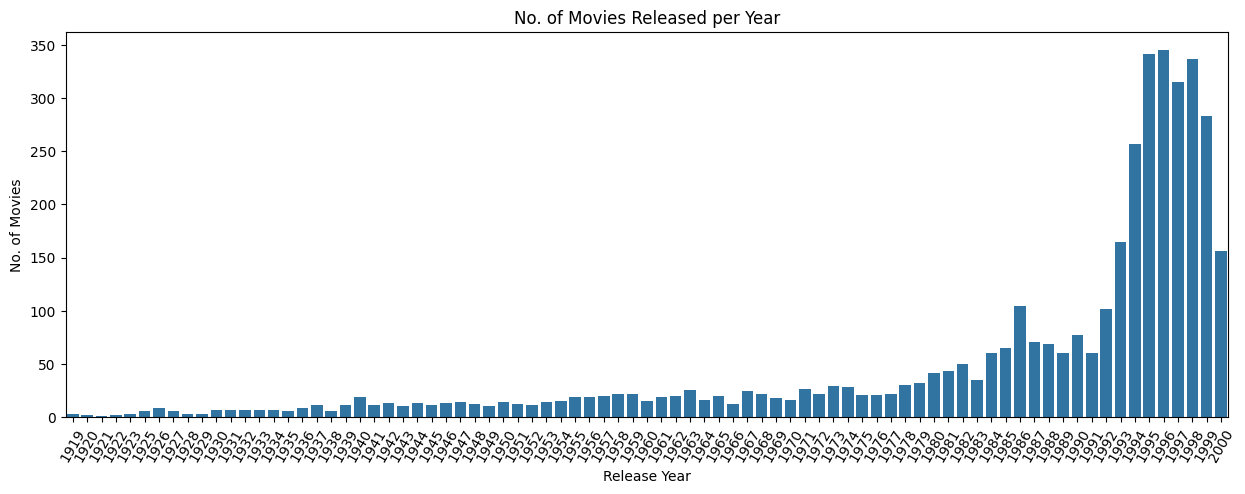

In [44]:
plt.figure(figsize=(15,5))
sns.barplot(x=movies['Release Year'].value_counts().index, y=movies['Release Year'].value_counts().values)
plt.xticks(rotation=60)
plt.xlabel('Release Year')
plt.ylabel('No. of Movies')
plt.title('No. of Movies Released per Year')
plt.show()

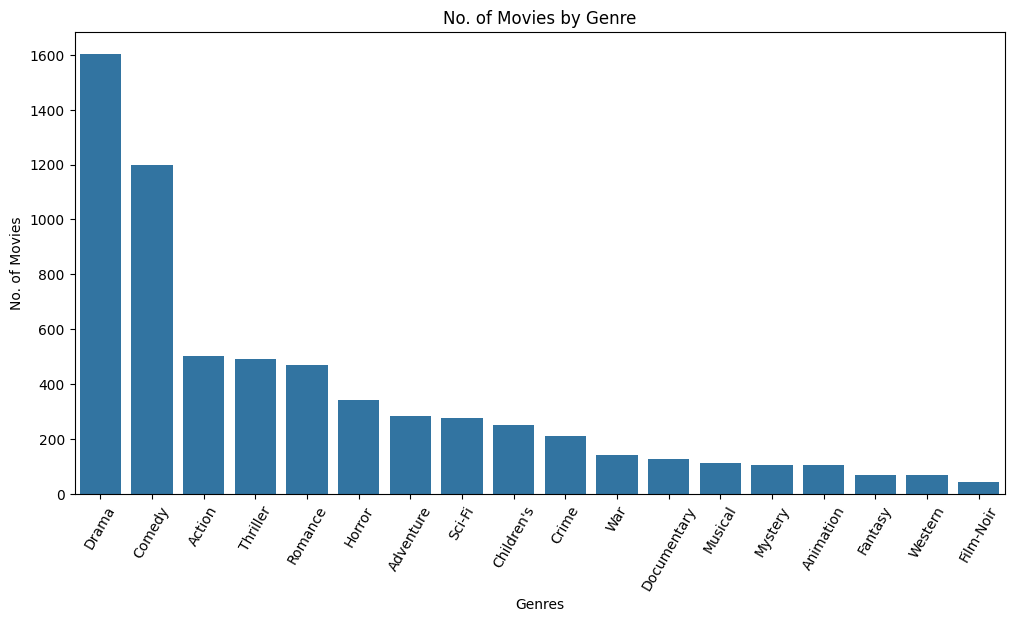

In [45]:
# Count of movies by Genre

genre_counts = movies['Genres'].str.split('|').explode().value_counts().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(x = genre_counts['Genres'], y = genre_counts['count'])
plt.xticks(rotation=60)
plt.xlabel('Genres')
plt.ylabel('No. of Movies')
plt.title('No. of Movies by Genre')
plt.show()

In [46]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
1,1,F,1,10,48067
2,2,M,56,16,70072
3,3,M,25,15,55117
4,4,M,45,7,2460
5,5,M,25,20,55455


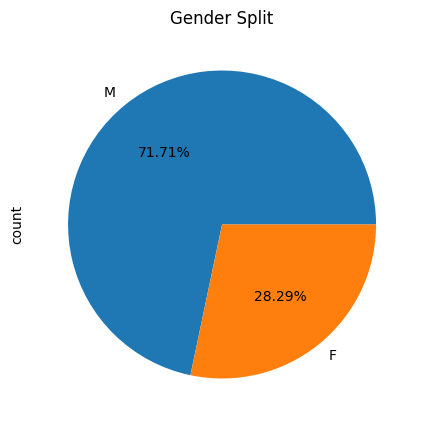

In [47]:
# User Gender Split
users['Gender'].value_counts().plot(kind='pie', autopct='%1.2f%%', figsize=(5,5))
plt.title('Gender Split')
plt.show()

In [48]:
users['Age'].value_counts()

,count
Age,
25,2096
35,1193
18,1103
45,550
50,496
56,380
1,222


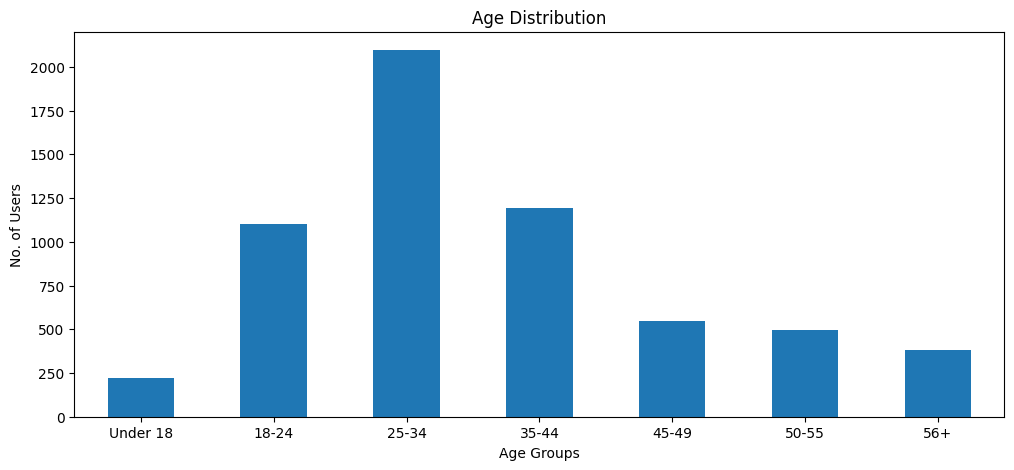

In [49]:
# User Age Distribution
age_groups = ['Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']
users['Age'].value_counts().sort_index().plot(kind='bar', figsize=(12,5))
plt.title('Age Distribution')
plt.xticks(range(len(age_groups)), age_groups, rotation = 0)
plt.xlabel('Age Groups')
plt.ylabel('No. of Users')
plt.show()

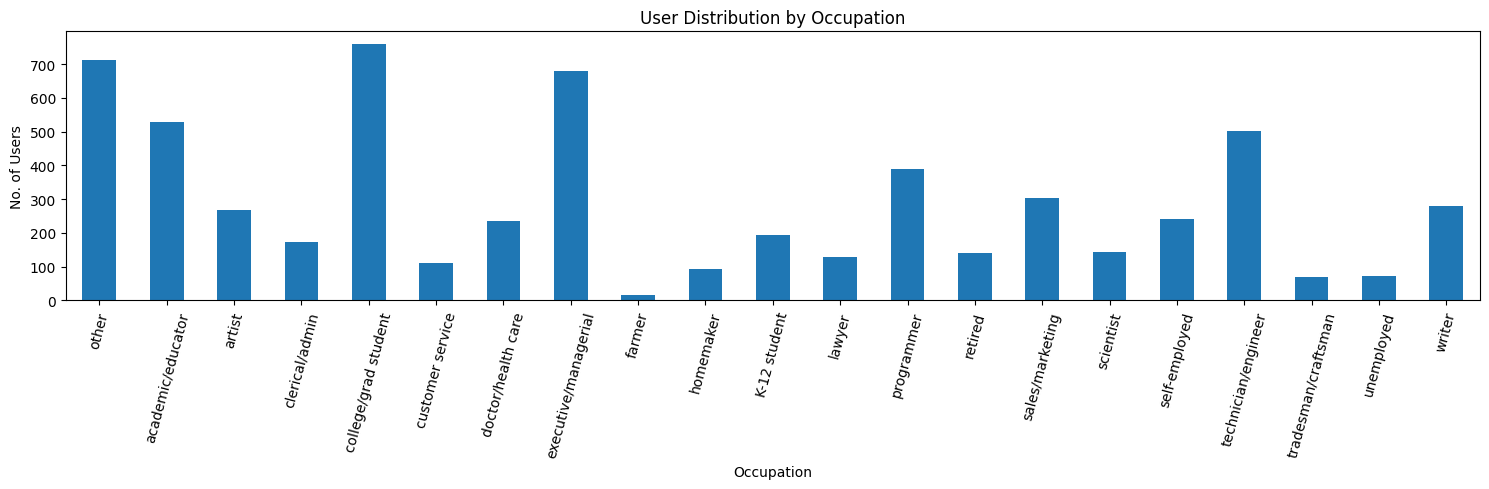

In [50]:
occ_groups = ['other', 'academic/educator', 'artist', 'clerical/admin', 'college/grad student', 'customer service', 'doctor/health care',
              'executive/managerial', 'farmer', 'homemaker', 'K-12 student', 'lawyer', 'programmer', 'retired', 'sales/marketing', 'scientist',
              'self-employed', 'technician/engineer', 'tradesman/craftsman', 'unemployed', 'writer']
users['Occupation'].value_counts().sort_index().plot(kind='bar', figsize=(15,5))
plt.title('User Distribution by Occupation')
plt.xticks(range(len(occ_groups)), occ_groups, rotation = 75)
plt.xlabel('Occupation')
plt.ylabel('No. of Users')
plt.tight_layout()
plt.show()

In [51]:
df_exploded = df.assign(Genres=df['Genres'].str.split('|')).explode('Genres', ignore_index=True)

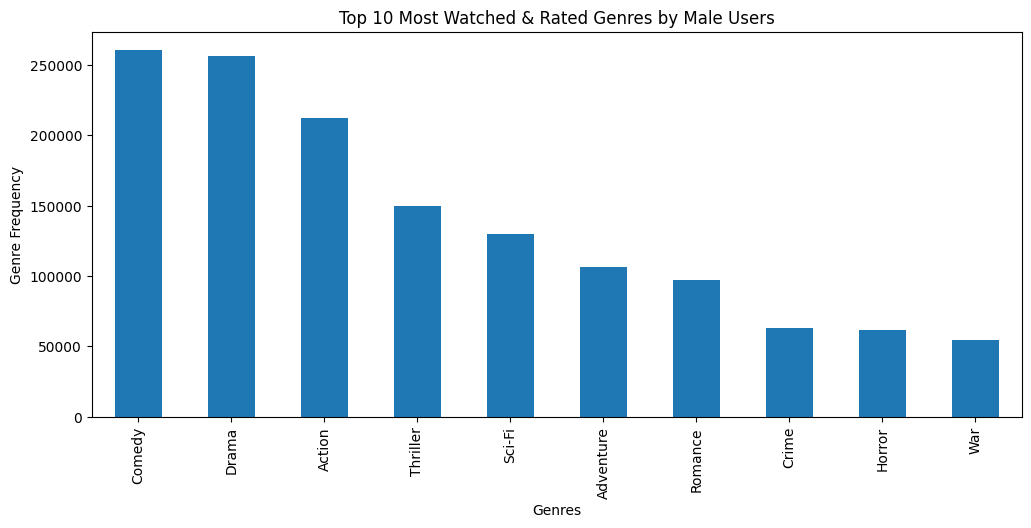

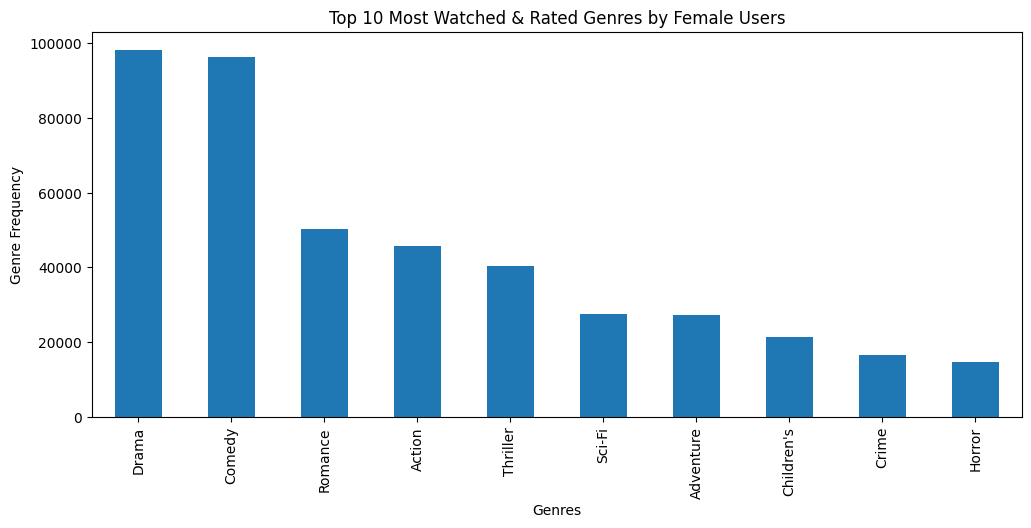

In [52]:
# Top 10 most watched and rated Genres by Genders

df_exploded[df_exploded.Gender == "M"]['Genres'].value_counts().head(10).plot(kind='bar', figsize=(12,5))
plt.title('Top 10 Most Watched & Rated Genres by Male Users')
plt.xlabel('Genres')
plt.ylabel('Genre Frequency')
plt.show()

df_exploded[df_exploded.Gender == "F"]['Genres'].value_counts().head(10).plot(kind='bar', figsize=(12,5))
plt.title('Top 10 Most Watched & Rated Genres by Female Users')
plt.xlabel('Genres')
plt.ylabel('Genre Frequency')
plt.show()

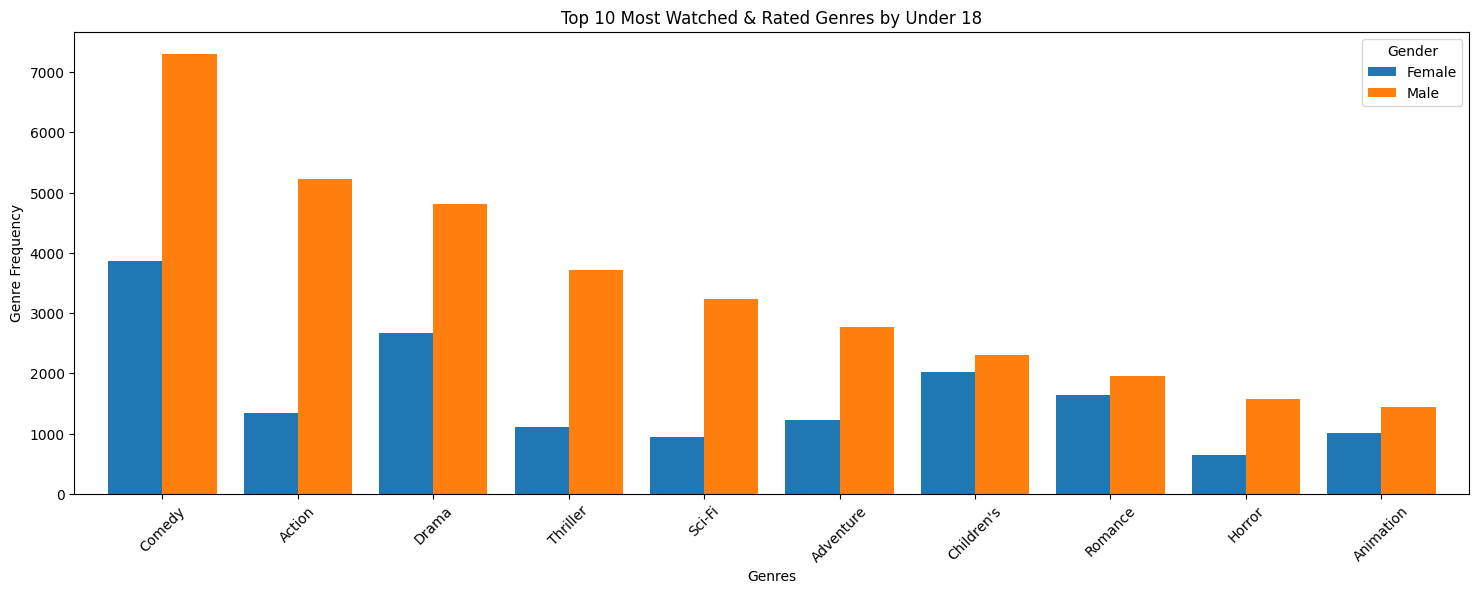

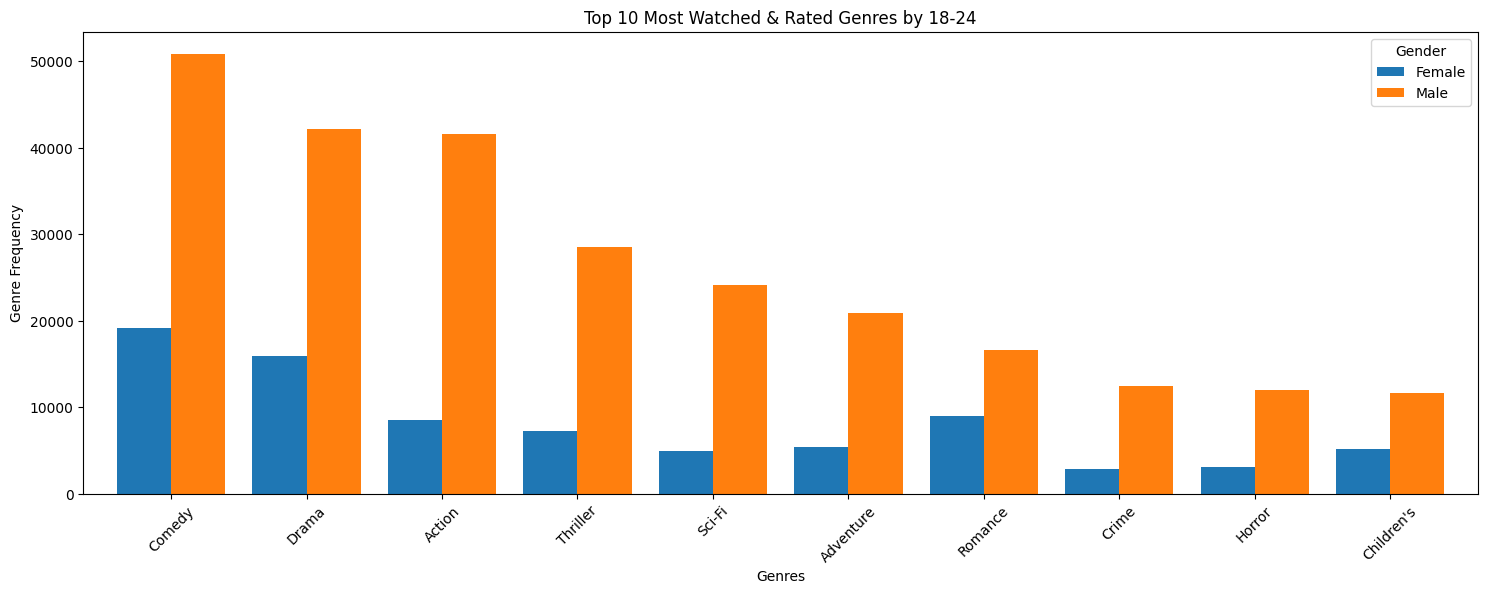

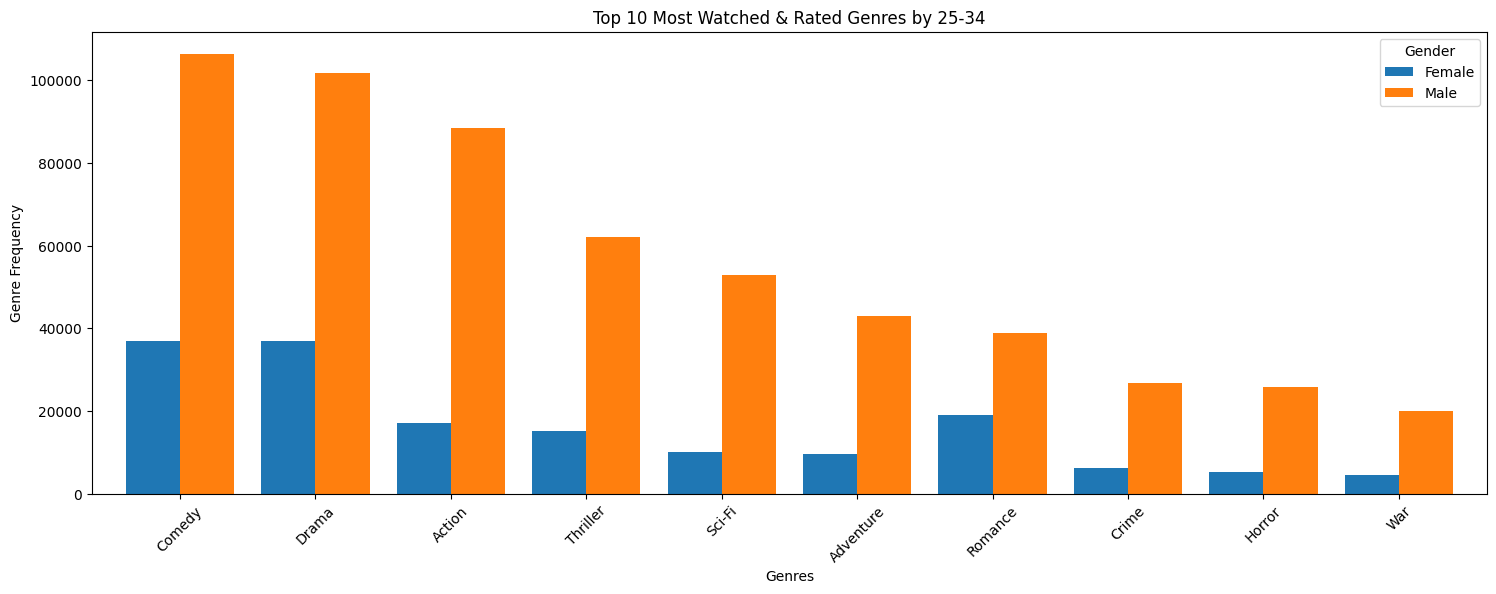

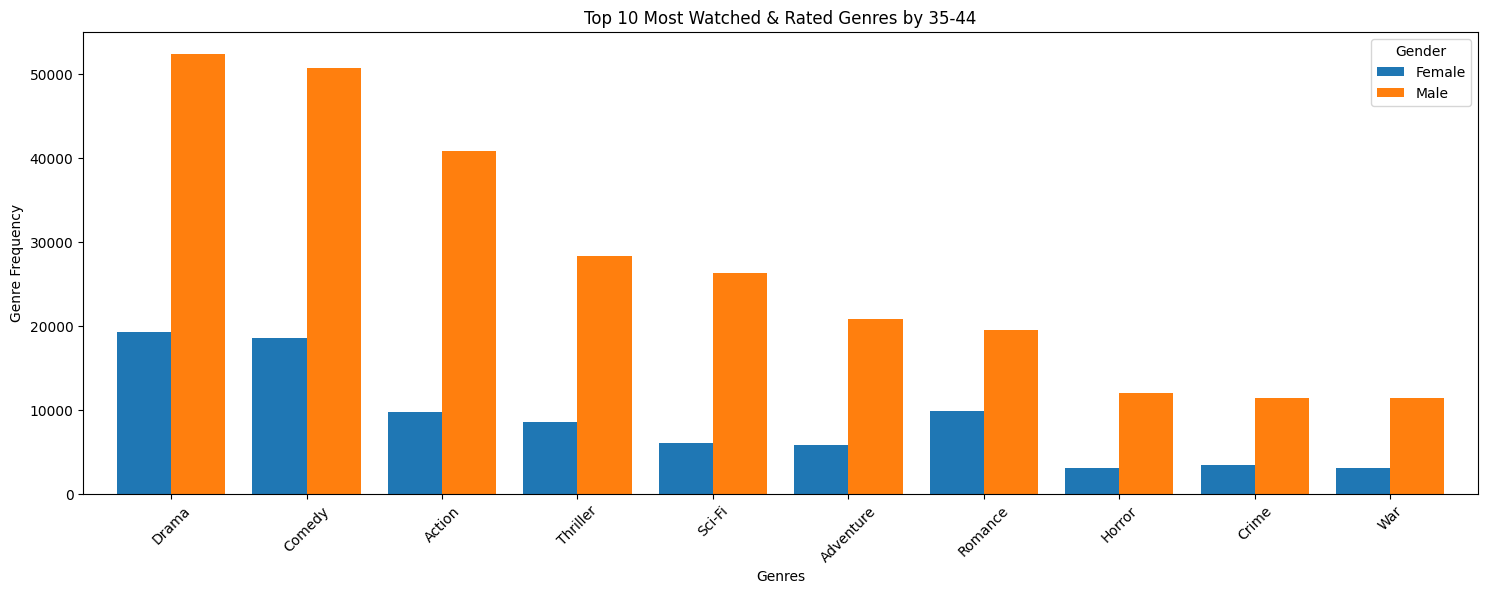

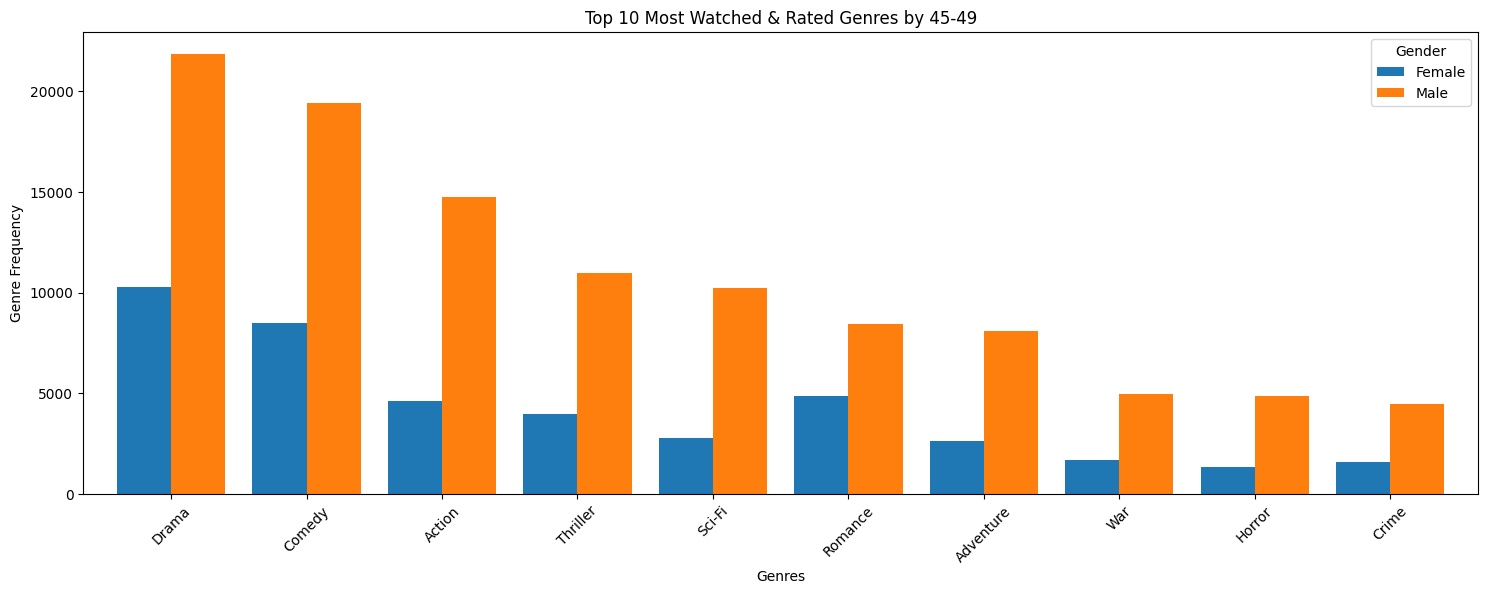

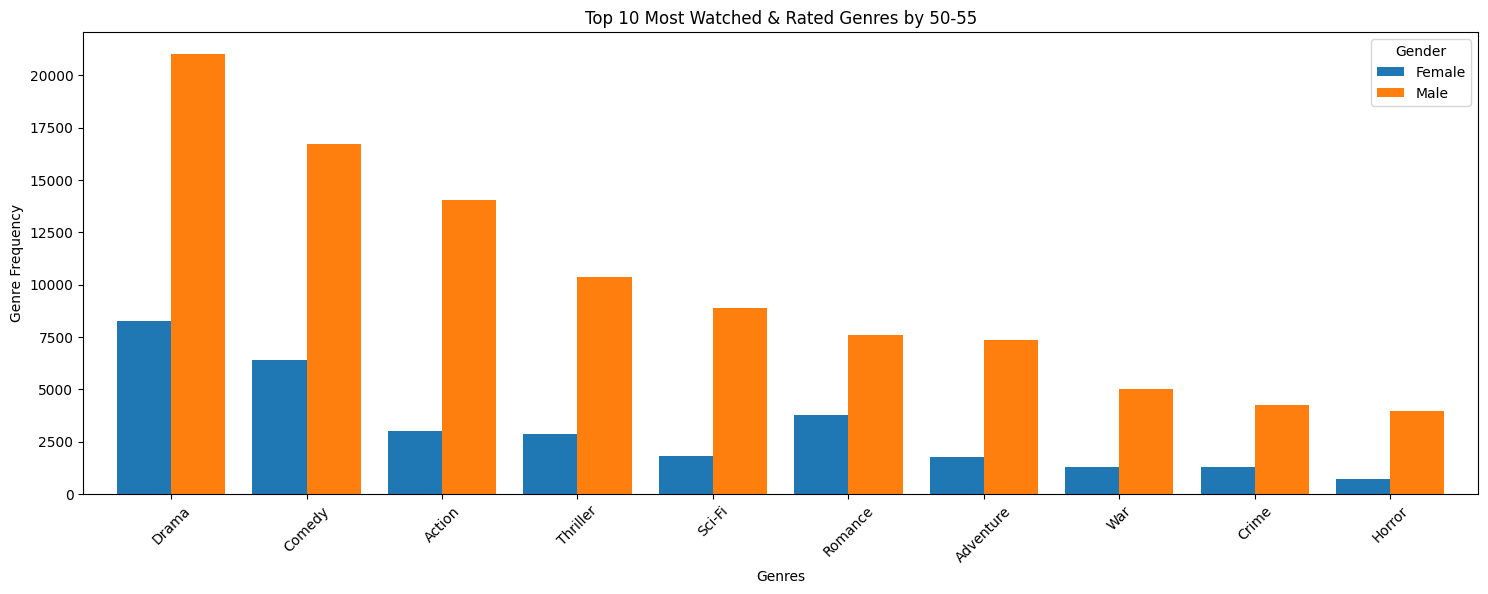

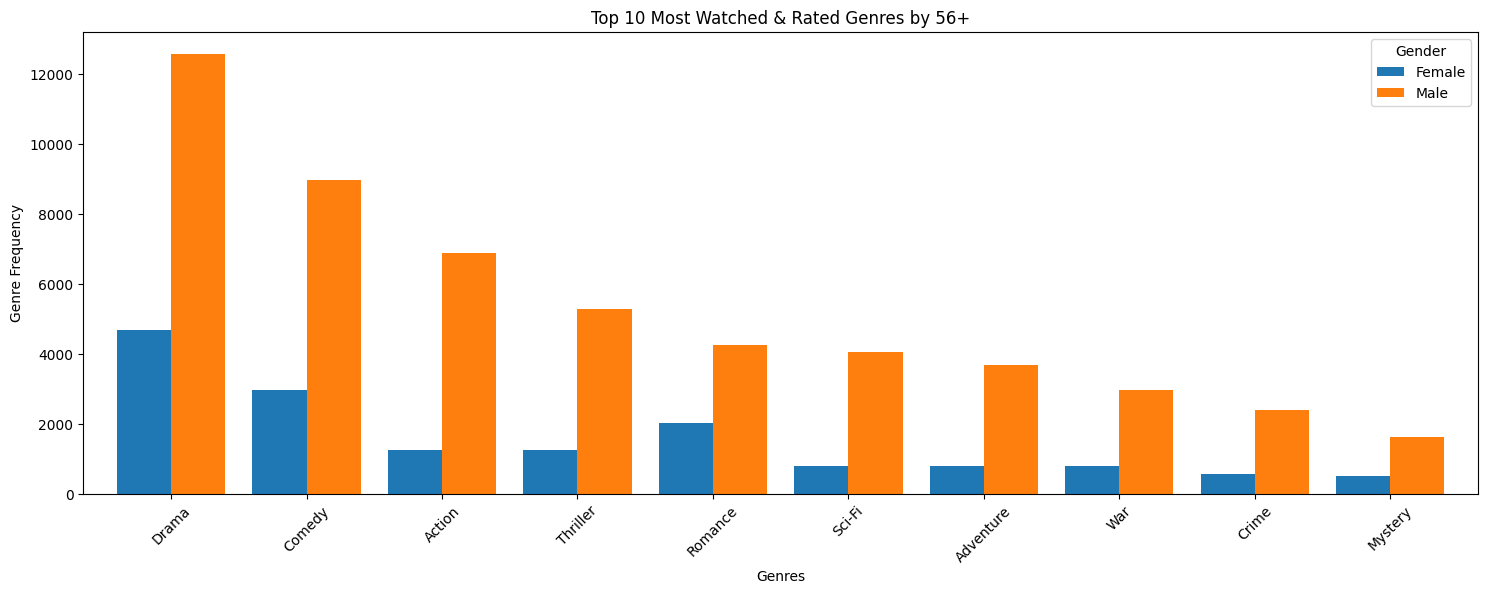

In [53]:
# Top 10 most watched and rated Genres by Age-group and Gender

age_ranges = {1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+"}

for label, group in age_ranges.items():
    age_group_data = df_exploded[df_exploded.Age == label]

    genre_gender_counts = age_group_data.groupby(['Genres', 'Gender']).size().unstack(fill_value=0).sort_values(by='M', ascending=False)

    genre_gender_counts.head(10).plot(kind='bar', figsize=(18, 6), width=0.8)

    plt.title(f'Top 10 Most Watched & Rated Genres by {group}')
    plt.xlabel('Genres')
    plt.ylabel('Genre Frequency')
    plt.xticks(rotation=45)
    plt.legend(title='Gender', labels=['Female', 'Male'], loc='upper right')
    plt.show()


In [54]:
# Movie Rating Range, Ratings Count and Average Ratings

movie_ratings = df.groupby('MovieID').agg({'Title':'first', 'Release Year':'first', 'Rating':['min', 'max', 'count', 'mean']}).sort_values(
    by=('Rating', 'count'), ascending=False).reset_index()
movie_ratings.columns = ['MovieID', 'Title', 'Release Year','Min Rating', 'Max Rating', 'Rating Count', 'Avg Rating']
movie_ratings['Title'] = movie_ratings['Title'].str.lstrip("")
movie_ratings['Title'] = movie_ratings['Title'].str.lstrip(" '")
movie_ratings.head(10)


,MovieID,Title,Release Year,Min Rating,Max Rating,Rating Count,Avg Rating
0,2858,American Beauty,1999,1,5,3428,4.317386
1,260,Star Wars: Episode IV - A New Hope,1977,1,5,2991,4.453694
2,1196,Star Wars: Episode V - The Empire Strikes Back,1980,1,5,2990,4.292977
3,1210,Star Wars: Episode VI - Return of the Jedi,1983,1,5,2883,4.022893
4,480,Jurassic Park,1993,1,5,2672,3.763847
5,2028,Saving Private Ryan,1998,1,5,2653,4.337354
6,589,Terminator 2: Judgment Day,1991,1,5,2649,4.058513
7,2571,The Matrix,1999,1,5,2590,4.315830
8,1270,Back to the Future,1985,1,5,2583,3.990321
9,593,The Silence of the Lambs,1991,1,5,2578,4.351823


In [55]:
movie_ratings['Avg Rating'].mean()

np.float64(3.238892177910891)

In [56]:
movie_ratings['Rating Count'].mean()

np.float64(269.88909875876953)

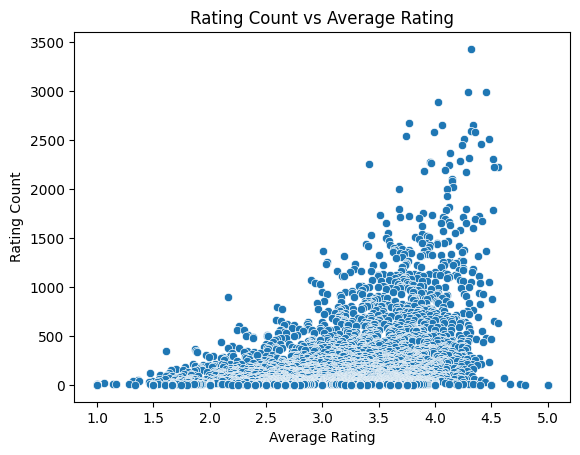

In [57]:
# Scatter plot of Average ratings of movies and Number of ratings

sns.scatterplot(data=movie_ratings, x='Avg Rating', y='Rating Count')
plt.title('Rating Count vs Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Rating Count')
plt.show()

##**EDA Questions**:

###**Q1. Users of which age group have watched and rated the most number of movies?** **bold text**

In [58]:
df.groupby('Age')['MovieID'].count().sort_values(ascending=False).head(1)

,MovieID
Age,
25,395556


####**Answer:**
Users aged 25-34 (Age Group 25 in dataset) have watched and rated the most number of movies.

###**Q2. Users belonging to which profession have watched and rated the most movies?**

In [59]:
df['Occupation'].value_counts().sort_values(ascending=False).head()

,count
Occupation,
4,131032
0,130499
7,105425
1,85351
17,72816


####**Answer:**
College/Grad students (Occupation Group 4 in dataset) have watched and rated the most number of movies

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 11 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   UserID        1000209 non-null  int64         
 1   MovieID       1000209 non-null  int64         
 2   Rating        1000209 non-null  int64         
 3   Timestamp     1000209 non-null  datetime64[ns]
 4   Title         1000209 non-null  object        
 5   Genres        1000209 non-null  object        
 6   Release Year  1000209 non-null  int64         
 7   Gender        1000209 non-null  object        
 8   Age           1000209 non-null  int64         
 9   Occupation    1000209 non-null  int64         
 10  Zip-code      1000209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 83.9+ MB


### **Q3. Most of the users in our dataset who’ve rated the movies are Male. (T/F)**

In [61]:
df['Gender'].value_counts(normalize=True)

,proportion
Gender,
M,0.753611
F,0.246389


####**Answer:**
75.36% of users who rated movies are Male. The statement is True.

### **Q4. Most of the movies present in our dataset were released in which decade?**

In [62]:
bins = [1910,1919,1929,1939,1949,1959,1969,1979,1989,1999,2009]
labels = ['1910s','1920s','1930s','1940s','1950s','1960s','1970s','1980s','1990s','2000s']
movies['Decade'] = pd.cut(movies['Release Year'], bins=bins, labels=labels)

In [63]:
movies['Decade'].value_counts().head()

,count
Decade,
1990s,2283
1980s,598
1970s,247
1960s,191
1950s,168


####**Answer:**
Most of the movies in the dataset were released in the 1990s.

In [64]:
movies.drop('Decade', axis=1, inplace=True)

### **Q5. The movie with maximum no. of ratings is ___.**

In [65]:
df['MovieID'].value_counts().head(1)

,count
MovieID,
2858,3428


In [66]:
movies[movies['MovieID'] == df['MovieID'].value_counts().head(5).index[0]][['MovieID','Title','Release Year']]

,MovieID,Title,Release Year
2790,2858,American Beauty,1999


####**Answer:**
American Beauty (1999) has the maximum number of ratings (3428).

..................................................................................................................................................................

#**Dataframe For Collaborative Filtering**

In [67]:
df.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Release Year,Gender,Age,Occupation,Zip-code
0,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest,Drama,1975,F,1,10,48067
1,1,661,3,2000-12-31 22:35:09,James and the Giant Peach,Animation|Children's|Musical,1996,F,1,10,48067
2,1,914,3,2000-12-31 22:32:48,My Fair Lady,Musical|Romance,1964,F,1,10,48067
3,1,3408,4,2000-12-31 22:04:35,Erin Brockovich,Drama,2000,F,1,10,48067
4,1,2355,5,2001-01-06 23:38:11,A Bug's Life,Animation|Children's|Comedy,1998,F,1,10,48067


In [68]:
df_matrix = df.pivot_table(index='UserID', columns='MovieID', values='Rating', fill_value=0)
df_matrix = df_matrix.astype(int)
df_matrix.head(10)

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,4,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0


In [69]:
df_matrix.shape

(6040, 3706)

In [70]:
df_matrix.columns

Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       3943, 3944, 3945, 3946, 3947, 3948, 3949, 3950, 3951, 3952],
      dtype='int64', name='MovieID', length=3706)

In [71]:
df['Title'] = df['Title'].str.lstrip()
df['Title'] = df['Title'].str.lstrip(" '")

In [72]:
movie_title_dict = movie_ratings.set_index('MovieID')['Title'].to_dict()

# **Recommender System Using Pearson Correlation**

In [73]:
movie_ratings.head()

,MovieID,Title,Release Year,Min Rating,Max Rating,Rating Count,Avg Rating
0,2858,American Beauty,1999,1,5,3428,4.317386
1,260,Star Wars: Episode IV - A New Hope,1977,1,5,2991,4.453694
2,1196,Star Wars: Episode V - The Empire Strikes Back,1980,1,5,2990,4.292977
3,1210,Star Wars: Episode VI - Return of the Jedi,1983,1,5,2883,4.022893
4,480,Jurassic Park,1993,1,5,2672,3.763847


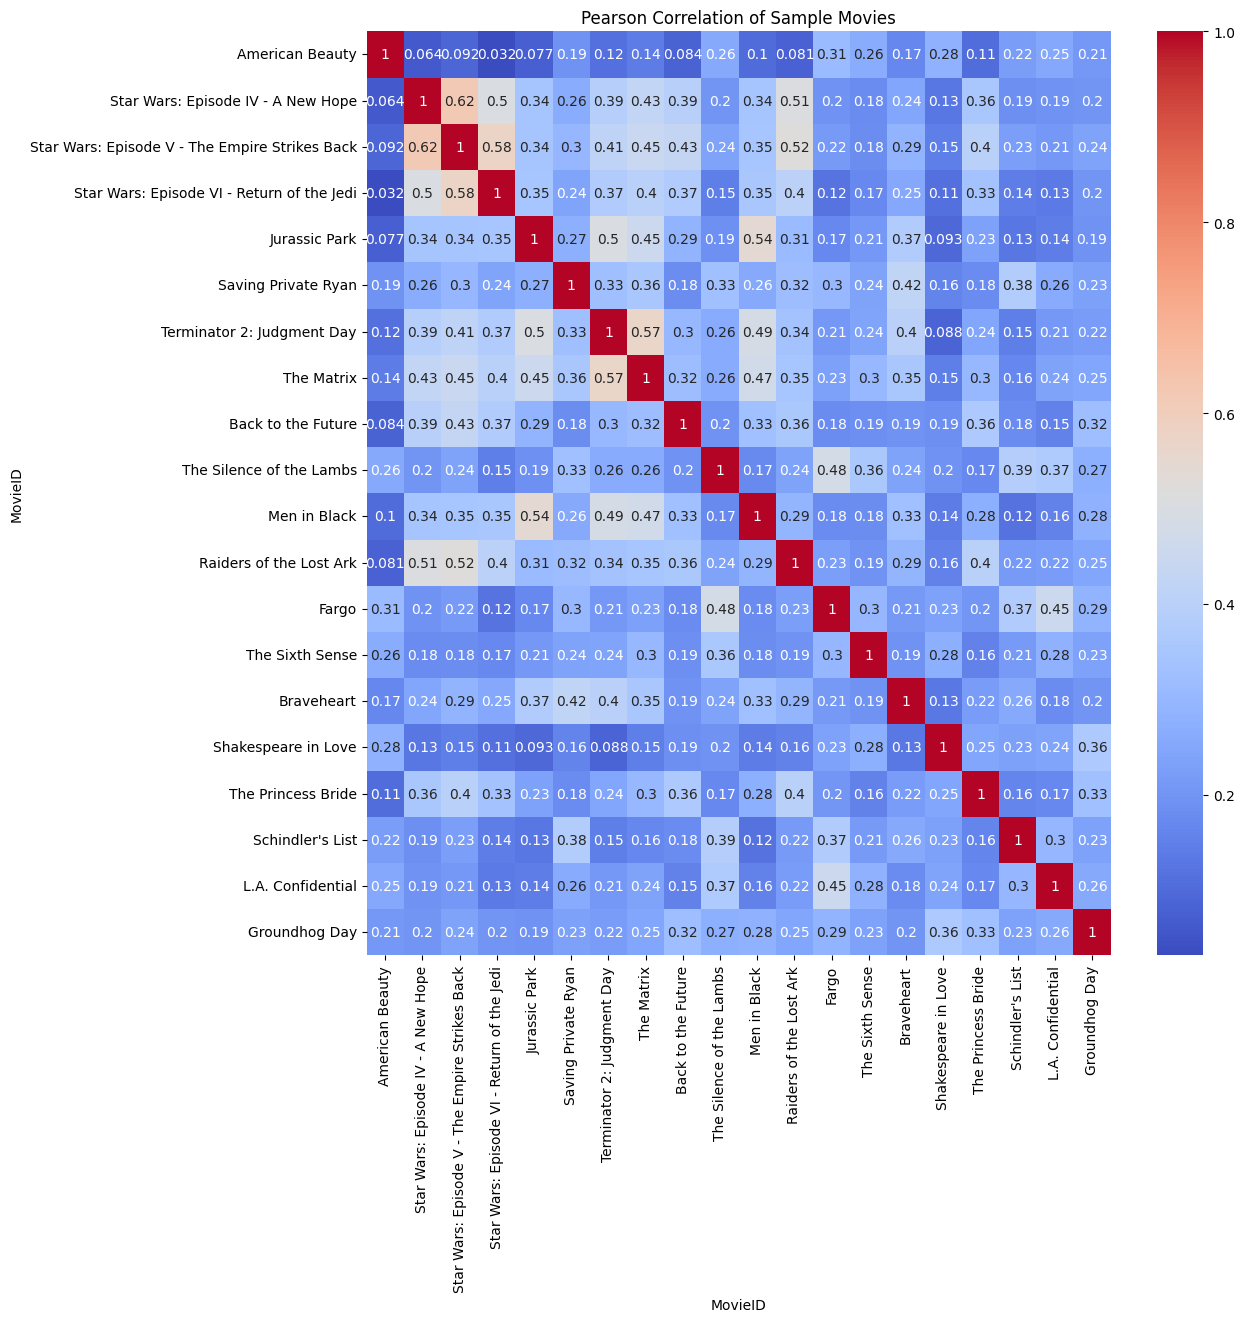

In [74]:
movie_sample = movie_ratings['MovieID'].head(20)

movie_corr_sample = df_matrix[movie_sample].corr()

# Replace MovieIDs with Titles for row and column labels
movie_corr_sample = movie_corr_sample.rename(index=movie_title_dict, columns=movie_title_dict)

# Plot the heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(movie_corr_sample, cmap='coolwarm', annot=True)
plt.title('Pearson Correlation of Sample Movies')
plt.show()


## **Recommending 5 Similar Movies Using Pearson Correlation:**

In [75]:
movie_ratings.head()

,MovieID,Title,Release Year,Min Rating,Max Rating,Rating Count,Avg Rating
0,2858,American Beauty,1999,1,5,3428,4.317386
1,260,Star Wars: Episode IV - A New Hope,1977,1,5,2991,4.453694
2,1196,Star Wars: Episode V - The Empire Strikes Back,1980,1,5,2990,4.292977
3,1210,Star Wars: Episode VI - Return of the Jedi,1983,1,5,2883,4.022893
4,480,Jurassic Park,1993,1,5,2672,3.763847


In [76]:
# Function to Recommend Movies based on Pearson Correlation


def corr_recommender(movie_matrix, n_recommendations=5):
    movie_title = input("Movie Title: ")
    if movie_title not in movie_title_dict.values():
        return 'Title not found'

    movie_id = next((k for k, v in movie_title_dict.items() if v == movie_title), None)

    corr_series = movie_matrix.corrwith(movie_matrix[movie_id])
    corr_series = corr_series.sort_values(ascending=False).head(n_recommendations+1)
    corr_series = corr_series.reset_index()
    corr_series = corr_series[corr_series['MovieID'] != movie_id]
    corr_series.columns = ['MovieID', 'Correlation']
    corr_series = corr_series.merge(movie_ratings[['MovieID','Title','Release Year', 'Avg Rating']], on='MovieID', how='left')
    corr_series = corr_series[['Title', 'Release Year', 'Avg Rating', 'Correlation']]
    print("-----"*8)
    return corr_series


In [77]:
# Example 1: Movies Similar to 2001: A Space Odyssey
corr_recommender(df_matrix, 5)

Movie Title: 2001: A Space Odyssey
----------------------------------------


,Title,Release Year,Avg Rating,Correlation
0,Close Encounters of the Third Kind,1977,4.014473,0.518251
1,Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb,1963,4.449890,0.514229
2,A Clockwork Orange,1971,4.078112,0.483638
3,Blade Runner,1982,4.273333,0.467666
4,Alien,1979,4.159585,0.447042


In [78]:
# Example 2: Movies Similar to American Beauty
corr_recommender(df_matrix, 5)

Movie Title: American Beauty
----------------------------------------


,Title,Release Year,Avg Rating,Correlation
0,Being John Malkovich,1999,4.125390,0.433136
1,Election,1999,3.930355,0.352922
2,Pulp Fiction,1994,4.278213,0.336978
3,Fight Club,1999,4.077188,0.319374
4,Clerks,1994,3.946884,0.315422


In [79]:
# Example 3: Movies Similar to 'Schindler's List'
corr_recommender(df_matrix, 5)

Movie Title: Schindler's List
----------------------------------------


,Title,Release Year,Avg Rating,Correlation
0,The Shawshank Redemption,1994,4.554558,0.456980
1,The Silence of the Lambs,1991,4.351823,0.387168
2,Saving Private Ryan,1998,4.337354,0.378579
3,Fargo,1996,4.254676,0.372775
4,Good Will Hunting,1997,4.176357,0.367450


In [80]:
# Example 4: Movies Similar to 'The Matrix'
corr_recommender(df_matrix, 5)

Movie Title: The Matrix
----------------------------------------


,Title,Release Year,Avg Rating,Correlation
0,Terminator 2: Judgment Day,1991,4.058513,0.565961
1,Total Recall,1990,3.682365,0.543301
2,The Fifth Element,1997,3.640523,0.515445
3,Face/Off,1997,3.401126,0.489569
4,The Terminator,1984,4.152050,0.483238


In [81]:
# Example 5: Movies Similar to "Pulp Fiction"
corr_recommender(df_matrix, 5)

Movie Title: Pulp Fiction
----------------------------------------


,Title,Release Year,Avg Rating,Correlation
0,GoodFellas,1990,4.275196,0.556034
1,Fargo,1996,4.254676,0.545127
2,Reservoir Dogs,1992,4.135822,0.522070
3,The Usual Suspects,1995,4.517106,0.510204
4,The Shawshank Redemption,1994,4.554558,0.474547


# **Recommender System Using Cosine Similarity**

In [82]:
from sklearn.metrics.pairwise import cosine_similarity

## **User-User Similarity Matrix**

In [83]:
user_similarity = cosine_similarity(df_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=df_matrix.index, columns=df_matrix.index)
user_similarity_df.head()

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.096382,0.120610,0.132455,0.090158,0.179222,0.059678,0.138241,0.226148,0.255288,...,0.170588,0.082006,0.069807,0.033663,0.114877,0.186329,0.135979,0.000000,0.174604,0.133590
2,0.096382,1.000000,0.151479,0.171176,0.114394,0.100865,0.305787,0.203337,0.190198,0.226861,...,0.112503,0.091222,0.268565,0.014286,0.183384,0.228241,0.206274,0.066118,0.066457,0.218276
3,0.120610,0.151479,1.000000,0.151227,0.062907,0.074603,0.138332,0.077656,0.126457,0.213655,...,0.092960,0.125864,0.161507,0.000000,0.097308,0.143264,0.107744,0.120234,0.094675,0.133144
4,0.132455,0.171176,0.151227,1.000000,0.045094,0.013529,0.130339,0.100856,0.093651,0.120738,...,0.163629,0.093041,0.382803,0.000000,0.082097,0.170583,0.127464,0.062907,0.064634,0.137968
5,0.090158,0.114394,0.062907,0.045094,1.000000,0.047449,0.126257,0.220817,0.261330,0.117052,...,0.100652,0.035732,0.061806,0.054151,0.179083,0.293365,0.172686,0.020459,0.027689,0.241437


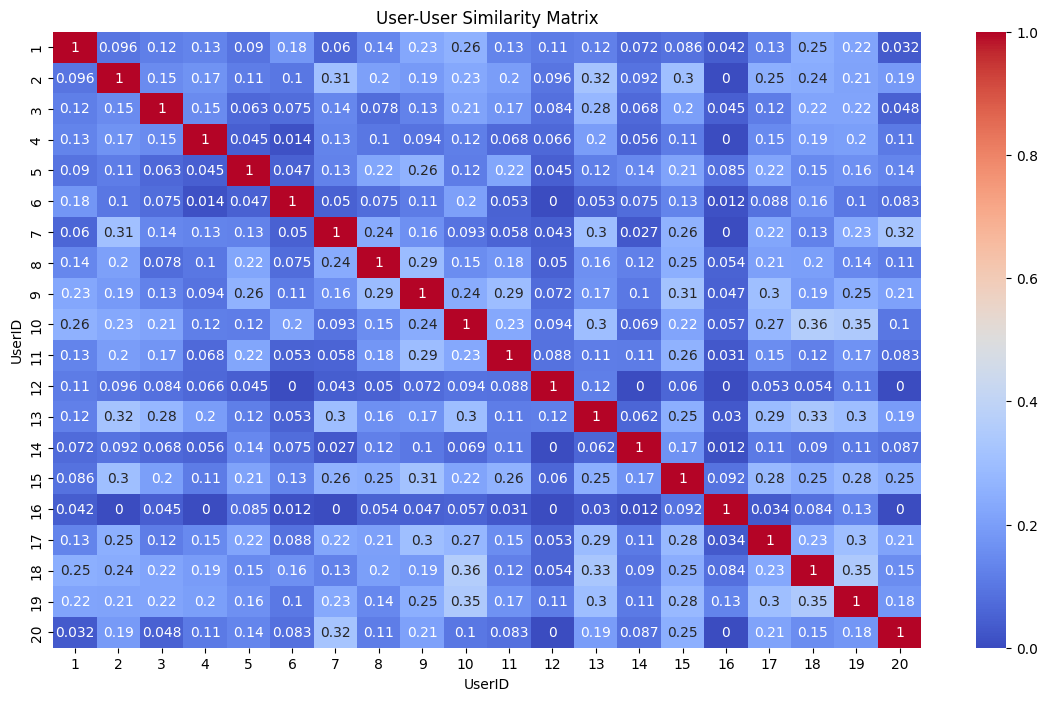

In [84]:
# Heatmap Visualisation of user-user sample
user_sample_matrix = user_similarity_df.iloc[:20,:20]
plt.figure(figsize=(14,8))
sns.heatmap(user_sample_matrix, cmap='coolwarm', annot=True)
plt.title('User-User Similarity Matrix')
plt.show()

## **Item-Item Similarity Matrix**

In [85]:
item_similarity = cosine_similarity(df_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=df_matrix.columns, columns=df_matrix.columns)
item_similarity_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
MovieID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.390349,0.267943,0.178789,0.256569,0.347373,0.301490,0.125709,0.106620,0.377459,...,0.099502,0.020966,0.084105,0.081826,0.045949,0.309676,0.186633,0.093479,0.042829,0.182691
2,0.390349,1.000000,0.240946,0.155457,0.249970,0.244827,0.262772,0.196521,0.158469,0.386200,...,0.061819,0.015209,0.075310,0.095573,0.074271,0.213650,0.140781,0.087013,0.026063,0.122185
3,0.267943,0.240946,1.000000,0.192788,0.308290,0.187020,0.292230,0.092122,0.128378,0.245601,...,0.038492,0.065507,0.049512,0.087377,0.050985,0.190575,0.104837,0.062258,0.010073,0.097786
4,0.178789,0.155457,0.192788,1.000000,0.271990,0.125170,0.220024,0.049554,0.060334,0.133707,...,0.055486,0.053300,0.002227,0.025278,0.025204,0.118902,0.096318,0.022588,0.024769,0.095154
5,0.256569,0.249970,0.308290,0.271990,1.000000,0.148114,0.305107,0.095512,0.138392,0.237681,...,0.026632,0.083898,0.046399,0.047542,0.016156,0.174554,0.092403,0.051633,0.010750,0.112835


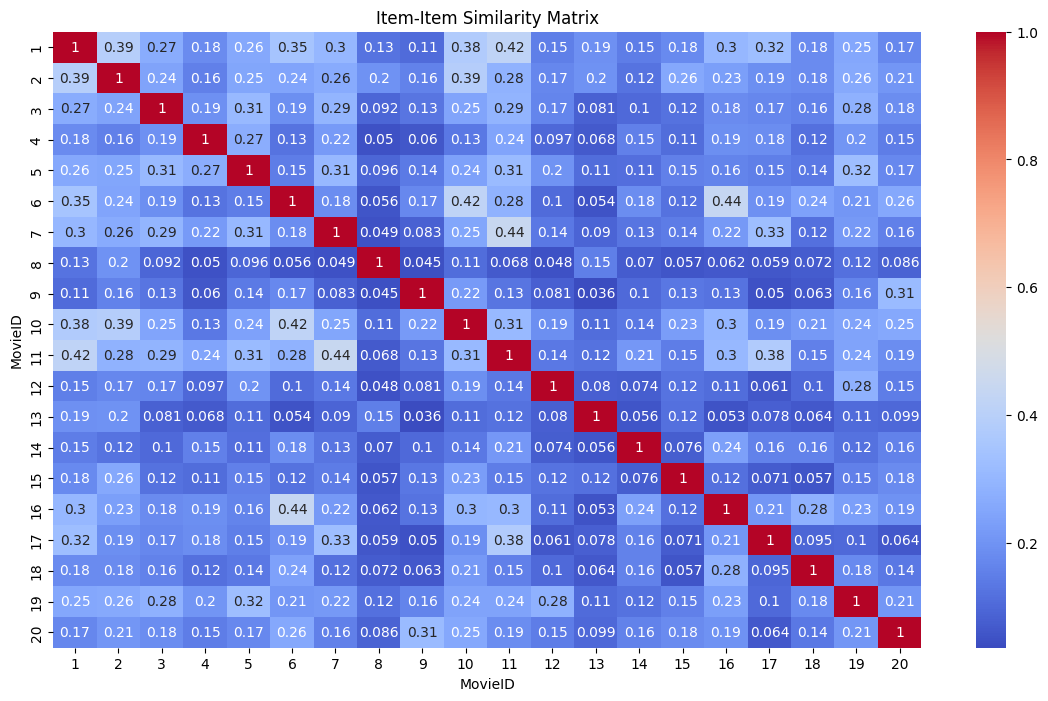

In [86]:
# Heatmap Visualisation of item-item sample
item_sample_matrix = item_similarity_df.iloc[:20,:20]
plt.figure(figsize=(14,8))
sns.heatmap(item_sample_matrix, cmap='coolwarm', annot=True)
plt.title('Item-Item Similarity Matrix')
plt.show()

In [87]:
temptest = item_similarity_df.loc[258].sort_values(ascending=False).head(6).reset_index()
temptest.columns = ['MovieID', 'Cosine Similarity']
temptest = temptest.merge(movie_ratings[['MovieID','Title','Release Year', 'Avg Rating']], on='MovieID', how='left')
temptest

,MovieID,Cosine Similarity,Title,Release Year,Avg Rating
0,258,1.000000,A Kid in King Arthur's Court,1995,2.423611
1,881,0.327872,First Kid,1996,2.623377
2,1702,0.315946,Flubber,1997,2.552980
3,558,0.314567,The Pagemaster,1994,2.703704
4,2042,0.313786,D2: The Mighty Ducks,1994,2.632124
5,1005,0.286143,D3: The Mighty Ducks,1996,2.373239


## **Recommending 5 Similar Movies Using Item-Item Cosine Similarity Matrix:**

In [88]:
# Function to Recommend Movies based on item-item cosine similarity


def cosine_recommender(n_recommendations=5):
    movie_title = input("Movie Title: ")
    if movie_title not in movie_title_dict.values():
        return 'Title not found'

    movie_id = next((k for k, v in movie_title_dict.items() if v == movie_title), None)

    similar_movies = item_similarity_df.loc[movie_id].sort_values(ascending=False).head(n_recommendations+1)
    similar_movies = pd.DataFrame(similar_movies)
    similar_movies = similar_movies.reset_index()
    similar_movies = similar_movies[similar_movies['MovieID'] != movie_id]
    similar_movies.columns = ['MovieID', 'Cosine Similarity']
    similar_movies = similar_movies.merge(movie_ratings[['MovieID','Title','Release Year', 'Avg Rating']], on='MovieID', how='left')
    similar_movies = similar_movies[['Title', 'Release Year', 'Avg Rating', 'Cosine Similarity']]
    print("-----"*8)
    return similar_movies


In [89]:
# Example 1: Movies Similar to 2001: A Space Odyssey
cosine_recommender(5)

Movie Title: 2001: A Space Odyssey
----------------------------------------


,Title,Release Year,Avg Rating,Cosine Similarity
0,Close Encounters of the Third Kind,1977,4.014473,0.636721
1,Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb,1963,4.449890,0.630860
2,Blade Runner,1982,4.273333,0.614559
3,Alien,1979,4.159585,0.607717
4,A Clockwork Orange,1971,4.078112,0.597646


In [90]:
# Example 2: Movies Similar to American Beauty
cosine_recommender(5)

Movie Title: Movies Similar to American Beauty


'Title not found'

In [91]:
# Example 3: Movies Similar to 'Schindler's List'
cosine_recommender(5)

Movie Title: Schindler's List
----------------------------------------


,Title,Release Year,Avg Rating,Cosine Similarity
0,The Shawshank Redemption,1994,4.554558,0.655410
1,The Silence of the Lambs,1991,4.351823,0.626305
2,Saving Private Ryan,1998,4.337354,0.624199
3,Fargo,1996,4.254676,0.613103
4,Pulp Fiction,1994,4.278213,0.590434


In [92]:
# Example 4: Movies Similar to 'Matrix, The'
cosine_recommender(5)

Movie Title: Matrix, The


'Title not found'

In [93]:
# Example 5: Movies Similar to "Pulp Fiction"
cosine_recommender(5)

Movie Title: Pulp Fiction
----------------------------------------


,Title,Release Year,Avg Rating,Cosine Similarity
0,Fargo,1996,4.254676,0.711598
1,GoodFellas,1990,4.275196,0.687168
2,The Usual Suspects,1995,4.517106,0.662759
3,The Shawshank Redemption,1994,4.554558,0.658751
4,The Silence of the Lambs,1991,4.351823,0.657366


# **Recommender System Using Nearest Neighbours (with Cosine Similarity)**

In [94]:
from sklearn.neighbors import NearestNeighbors

### **Creating a CSR Matrix**

In [95]:
from scipy.sparse import csr_matrix

In [96]:
df_csr = df.pivot_table(index='UserID', columns='MovieID', values='Rating')
df_csr = df_csr.fillna(0)
df_csr = df_csr.astype(int)
csr_data = csr_matrix(df_csr)

In [97]:
coo_data = csr_data.tocoo()
print(f"User (row) indices: {coo_data.row[:10]}")  # First 10 user indices
print(f"Movie (col) indices: {coo_data.col[:10]}") # First 10 movie indices
print(f"Ratings: {coo_data.data[:10]}")

User (row) indices: [0 0 0 0 0 0 0 0 0 0]
Movie (col) indices: [  0  47 144 253 513 517 574 580 581 593]
Ratings: [5 5 5 4 5 4 4 4 5 4]


In [98]:
df_matrix.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
df_csr.loc[0:5,60:70]

MovieID,60,61,62,63,64,65,66,67,68,69,70
UserID,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0


### **Recommendation Function**

In [100]:
def nn_recommender(n_recommendations=5):
    movie_title = input("Movie Title: ").strip()


    if movie_title not in movie_ratings['Title'].values:
        return f'{movie_title} not found'


    movie_id = movie_ratings[movie_ratings['Title'] == movie_title]['MovieID'].values[0]
    print("-----"*8)
    print(f"{n_recommendations} movies similar to {movie_title:}")


    model_knn = NearestNeighbors(metric='cosine')
    model_knn.fit(csr_data.T)


    movie_index = df_csr.columns.get_loc(movie_id)


    movie_vector = csr_data.T[movie_index].reshape(1, -1)


    distances, indices = model_knn.kneighbors(movie_vector, n_neighbors=n_recommendations + 1)


    recommended_indices = indices.flatten()[1:]
    recommended_distances = distances.flatten()[1:]


    recommended_movie_ids = df_csr.columns[recommended_indices]
    similar_movies = movie_ratings[movie_ratings['MovieID'].isin(recommended_movie_ids)]
    similar_movies = similar_movies.iloc[:,[0,1,2,6]]


    similar_movies['Distances'] = recommended_distances
    similar_movies = similar_movies[['Title', 'Release Year','Avg Rating', 'Distances']]

    print("-----" * 8)

    return similar_movies




### **Recommending 5 Similar Movies Using Nearest Nieghbours Cosine Similarity Matrix:**

In [101]:
# Example 1: Movies Similar to 2001: A Space Odyssey
nn_recommender(5)

Movie Title: 2001: A Space Odyssey
----------------------------------------
5 movies similar to 2001: A Space Odyssey
----------------------------------------


,Title,Release Year,Avg Rating,Distances
30,Alien,1979,4.159585,0.363279
35,Blade Runner,1982,4.273333,0.369140
73,Close Encounters of the Third Kind,1977,4.014473,0.385441
90,Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb,1963,4.449890,0.392283
125,A Clockwork Orange,1971,4.078112,0.402354


In [102]:
# Example 2: Movies Similar to American Beauty
nn_recommender(5)

Movie Title: American Beauty
----------------------------------------
5 movies similar to American Beauty
----------------------------------------


,Title,Release Year,Avg Rating,Distances
9,The Silence of the Lambs,1991,4.351823,0.328538
12,Fargo,1996,4.254676,0.374798
15,Shakespeare in Love,1998,4.127480,0.385092
22,Being John Malkovich,1999,4.125390,0.393904
27,Pulp Fiction,1994,4.278213,0.398433


In [103]:
# Example 3: Movies Similar to 'Schindler's List'
nn_recommender(5)

Movie Title: Schindler's List
----------------------------------------
5 movies similar to Schindler's List
----------------------------------------


,Title,Release Year,Avg Rating,Distances
5,Saving Private Ryan,1998,4.337354,0.344590
9,The Silence of the Lambs,1991,4.351823,0.373695
12,Fargo,1996,4.254676,0.375801
23,The Shawshank Redemption,1994,4.554558,0.386897
27,Pulp Fiction,1994,4.278213,0.409566


In [104]:
# Example 4: Movies Similar to 'Matrix, The'
nn_recommender(5)

Movie Title: The Matrix
----------------------------------------
5 movies similar to The Matrix
----------------------------------------


,Title,Release Year,Avg Rating,Distances
1,Star Wars: Episode IV - A New Hope,1977,4.453694,0.254468
2,Star Wars: Episode V - The Empire Strikes Back,1980,4.292977,0.296735
6,Terminator 2: Judgment Day,1991,4.058513,0.310541
10,Men in Black,1997,3.739953,0.315237
31,Total Recall,1990,3.682365,0.319622


In [105]:
# Example 5: Movies Similar to "Pulp Fiction"
nn_recommender(5)

Movie Title: Pulp Fiction
----------------------------------------
5 movies similar to Pulp Fiction
----------------------------------------


,Title,Release Year,Avg Rating,Distances
9,The Silence of the Lambs,1991,4.351823,0.288402
12,Fargo,1996,4.254676,0.312832
23,The Shawshank Redemption,1994,4.554558,0.337241
38,The Usual Suspects,1995,4.517106,0.341249
52,GoodFellas,1990,4.275196,0.342634


#**Recommendation System Based on Matrix Factorization Using cmfrec Library**

##**Preparing Library & Dataset**

In [106]:
!pip install cmfrec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached findblas-0.1.26.post1-py3-none-any.whl
  Created wheel for cmfrec: filename=cmfrec-3.5.1.post13-cp311-cp311-linux_x86_64.whl size=5751631 sha256=79af62652bc4f19980178a3c16e706fef6ac6197bb998573b8215c45e9b4a6f3
  Stored in directory: /root/.cache/pip/wheels/16/70/88/1f79fa4894c838ed64d0ab7833a5c7166610f8bfdf79f70c70
Successfully built cmfrec


In [107]:
from cmfrec import CMF
import cmfrec

In [108]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape

In [109]:
df.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Release Year,Gender,Age,Occupation,Zip-code
0,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest,Drama,1975,F,1,10,48067
1,1,661,3,2000-12-31 22:35:09,James and the Giant Peach,Animation|Children's|Musical,1996,F,1,10,48067
2,1,914,3,2000-12-31 22:32:48,My Fair Lady,Musical|Romance,1964,F,1,10,48067
3,1,3408,4,2000-12-31 22:04:35,Erin Brockovich,Drama,2000,F,1,10,48067
4,1,2355,5,2001-01-06 23:38:11,A Bug's Life,Animation|Children's|Comedy,1998,F,1,10,48067


In [110]:
mf_data = df.iloc[:,:3]
mf_data.columns = ['UserId', 'ItemId', 'Rating']
print(mf_data.shape)
mf_data.head()

(1000209, 3)


,UserId,ItemId,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [153]:
running = input("Run again? (y/n): ")

Run again? (y/n): n


In [152]:
mf_data.head()

,UserId,ItemId,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


##**Fitting Model**

###**Model 1: d = 2**

In [111]:
mf_model = CMF(method="als", k=2, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)

mf_model.fit(mf_data)

Collective matrix factorization model
(explicit-feedback variant)


In [112]:
mf_model.A_.shape, mf_model.B_.shape

((6040, 2), (3706, 2))

###**Model 2: d = 4**

In [113]:
mf_model2 = CMF(method="als", k=4, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)

mf_model2.fit(mf_data)

Collective matrix factorization model
(explicit-feedback variant)


In [114]:
mf_model2.A_.shape, mf_model2.B_.shape

((6040, 4), (3706, 4))

###**Model 3: d = 8**

In [115]:
mf_model3 = CMF(method="als", k=8, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)

mf_model3.fit(mf_data)

Collective matrix factorization model
(explicit-feedback variant)


In [116]:
mf_model3.A_.shape, mf_model3.B_.shape

((6040, 8), (3706, 8))

###**Model 4: d = 20**

In [117]:
mf_model4 = CMF(method="als", k=20, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)

mf_model4.fit(mf_data)

Collective matrix factorization model
(explicit-feedback variant)


In [118]:
mf_model4.A_.shape, mf_model4.B_.shape

((6040, 20), (3706, 20))

##Using model to predict ratings

In [119]:
mf_data_eval = mf_data.copy(deep=True)

In [120]:
predictions_m1 = mf_model.predict(user=mf_data['UserId'].values, item=mf_data['ItemId'].values)

In [121]:
mf_data_eval['Model1_Predicted_Rating'] = predictions_m1

In [122]:
predictions_m2 = mf_model2.predict(user=mf_data['UserId'].values, item=mf_data['ItemId'].values)

In [123]:
mf_data_eval['Model2_Predicted_Rating'] = predictions_m2

In [124]:
predictions_m3 = mf_model3.predict(user=mf_data['UserId'].values, item=mf_data['ItemId'].values)

In [125]:
mf_data_eval['Model3_Predicted_Rating'] = predictions_m3

In [126]:
predictions_m4 = mf_model4.predict(user=mf_data['UserId'].values, item=mf_data['ItemId'].values)

In [127]:
mf_data_eval['Model4_Predicted_Rating'] = predictions_m4

In [128]:
mf_data_eval.head(5)

,UserId,ItemId,Rating,Model1_Predicted_Rating,Model2_Predicted_Rating,Model3_Predicted_Rating,Model4_Predicted_Rating
0,1,1193,5,4.098743,4.075756,4.375567,4.553211
1,1,661,3,4.045168,3.918417,3.435272,3.064257
2,1,914,3,4.295278,4.345438,4.083409,4.076628
3,1,3408,4,4.152456,4.162765,4.216707,4.048296
4,1,2355,5,4.140216,4.139352,3.899650,4.466180


##**Model Evaluation : RMSE & MAPE**

In [129]:
# Comparing means of Actual Rating and Predicted Ratings

print (f'Mean of Actual Ratings: {mf_data.Rating.mean()}')
print()
print(f'Mean of Predicted Ratings of Model 1 (d=2):{mf_data_eval["Model1_Predicted_Rating"].mean()}')
print()
print(f'Mean of Predicted Ratings of Model 2 (d=4): {mf_data_eval["Model2_Predicted_Rating"].mean()}')
print()
print(f'Mean of Predicted Ratings of Model 3 (d=8): {mf_data_eval["Model3_Predicted_Rating"].mean()}')
print()
print(f'Mean of Predicted Ratings of Model 4 (d=20): {mf_data_eval["Model4_Predicted_Rating"].mean()}')


Mean of Actual Ratings: 3.581564453029317

Mean of Predicted Ratings of Model 1 (d=2):3.585503578186035

Mean of Predicted Ratings of Model 2 (d=4): 3.5820999145507812

Mean of Predicted Ratings of Model 3 (d=8): 3.5819506645202637

Mean of Predicted Ratings of Model 4 (d=20): 3.5819268226623535


In [130]:
# RMSE of Models

print("RMSE of Model1 :", mse(mf_data_eval['Rating'], mf_data_eval['Model1_Predicted_Rating'])**0.5)

print("RMSE of Model2:", mse(mf_data_eval['Rating'], mf_data_eval['Model2_Predicted_Rating'])**0.5)

print("RMSE of Model3:", mse(mf_data_eval['Rating'], mf_data_eval['Model3_Predicted_Rating'])**0.5)

print("RMSE of Model4:", mse(mf_data_eval['Rating'], mf_data_eval['Model4_Predicted_Rating'])**0.5)


RMSE of Model1 : 0.8747949359926886
RMSE of Model2: 0.828562998552612
RMSE of Model3: 0.7795605512178876
RMSE of Model4: 0.6886728426298461


In [131]:
# MAPE of Models
print("MAPE of Model1:", mape(mf_data_eval['Rating'], mf_data_eval['Model1_Predicted_Rating']))
print("MAPE of Model2:", mape(mf_data_eval['Rating'], mf_data_eval['Model2_Predicted_Rating']))
print("MAPE of Model3:", mape(mf_data_eval['Rating'], mf_data_eval['Model3_Predicted_Rating']))
print("MAPE of Model4:", mape(mf_data_eval['Rating'], mf_data_eval['Model4_Predicted_Rating']))

MAPE of Model1: 0.2659049928188324
MAPE of Model2: 0.2475268393754959
MAPE of Model3: 0.22885502874851227
MAPE of Model4: 0.19513247907161713


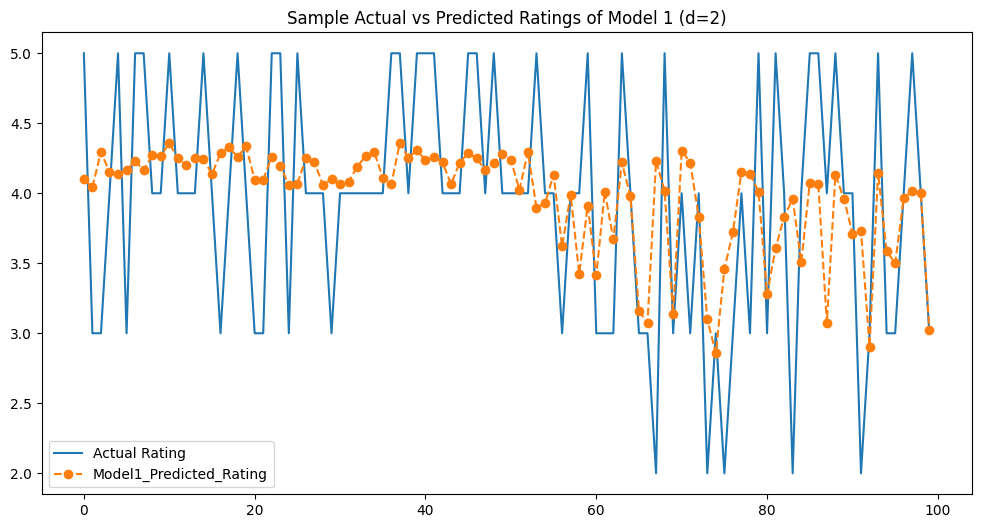

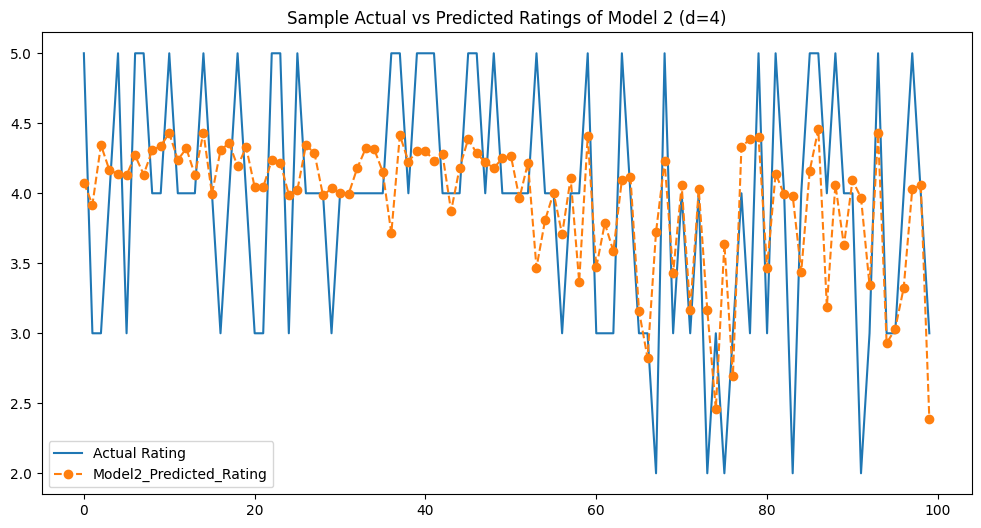

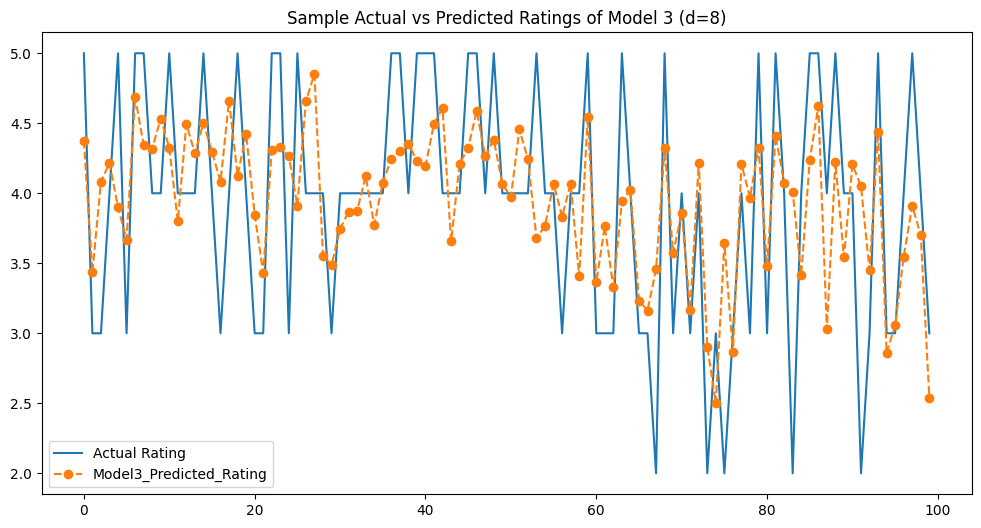

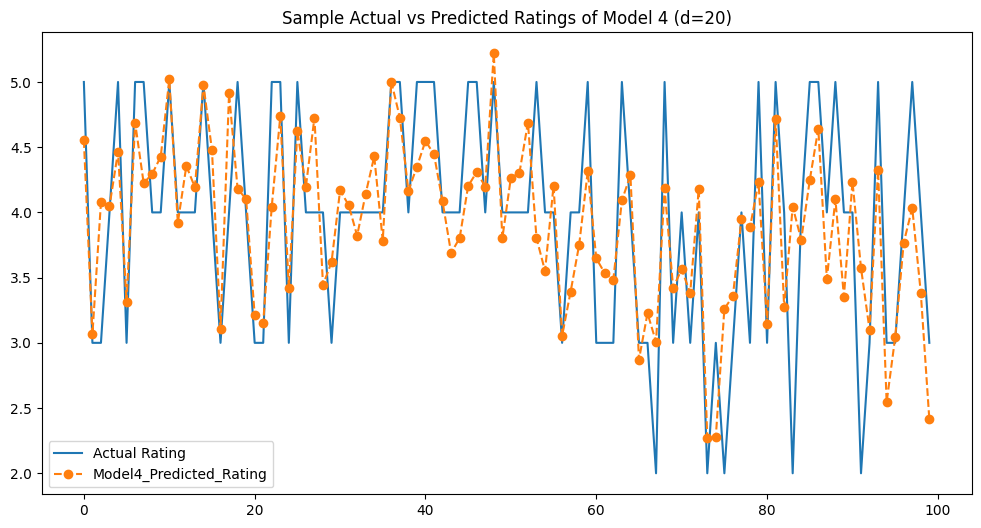

In [132]:
plt.figure(figsize=(12,6))
plt.plot(mf_data_eval['Rating'].head(100), label='Actual Rating')
plt.plot(mf_data_eval['Model1_Predicted_Rating'].head(100), label='Model1_Predicted_Rating', linestyle='dashed', marker='o')
plt.title('Sample Actual vs Predicted Ratings of Model 1 (d=2)')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(mf_data_eval['Rating'].head(100), label='Actual Rating')
plt.plot(mf_data_eval['Model2_Predicted_Rating'].head(100), label='Model2_Predicted_Rating', linestyle='dashed', marker='o')
plt.title('Sample Actual vs Predicted Ratings of Model 2 (d=4)')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(mf_data_eval['Rating'].head(100), label='Actual Rating')
plt.plot(mf_data_eval['Model3_Predicted_Rating'].head(100), label='Model3_Predicted_Rating', linestyle='dashed', marker='o')
plt.title('Sample Actual vs Predicted Ratings of Model 3 (d=8)')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(mf_data_eval['Rating'].head(100), label='Actual Rating')
plt.plot(mf_data_eval['Model4_Predicted_Rating'].head(100), label='Model4_Predicted_Rating', linestyle='dashed', marker='o')
plt.title('Sample Actual vs Predicted Ratings of Model 4 (d=20)')
plt.legend()
plt.show()

##**Matrix Factorization Recommendation Models Report:**

* Using the cmfrec library we applied Matrix Factorization to create 3 models
  * Model 1: With latent factors / dimensionality of factor matrices, d = 2
  * Model 2: With d = 4
  * Model 3: With d = 8
  * Model 4: With d = 20

* The models were trained on a user-item-ratings dataset with 6040 users and their ratings of 3706 movies.

* Model 1 has an RMSE of 0.874 and a MAPE of 0.265
* Model 2 has an RMSE of 0.828 and a MAPE of 0.247
* Model 3 has an RMSE of 0.779 and a MAPE of 0.228
* Model 4 has an RMSE of 0.688 and a MAPE of 0.195

* It is observed that as dimensionality (d) increases the prediction the model RMSE and MAPE improves.

* The models can be further improved by optimizing d and including user and item biases.




# **Predictor Based on Matrix Factorization**

In [133]:
mf_data.head()

,UserId,ItemId,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [134]:
mf_data.isna().sum()

,0
UserId,0
ItemId,0
Rating,0


## **Visualizing Embeddings**

In [135]:
from sklearn.decomposition import PCA

In [136]:
user_factors = mf_model4.A_
item_factors = mf_model4.B_

In [137]:
predicted_matrix = np.dot(user_factors, item_factors.T)
predicted_matrix = pd.DataFrame(predicted_matrix, index=mf_data['UserId'].unique(), columns=mf_data['ItemId'].unique())
predicted_matrix.shape

(6040, 3706)

In [138]:
df_matrix.shape

(6040, 3706)

In [139]:
pca = PCA(n_components=2)
user_factors_2d = pca.fit_transform(user_factors)
item_factors_2d = pca.fit_transform(item_factors)

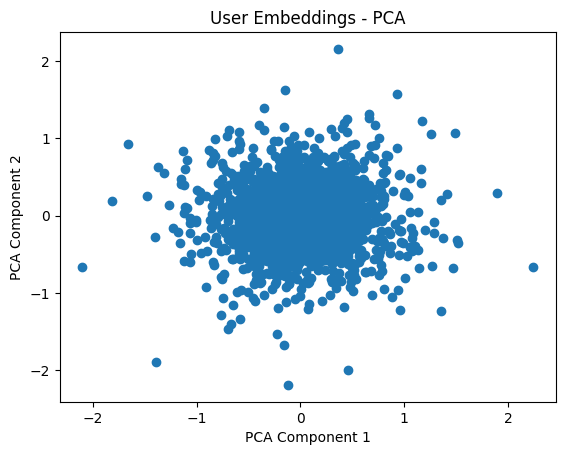

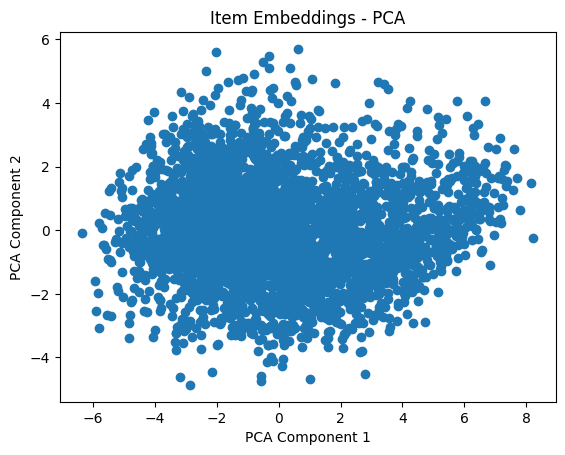

In [140]:
plt.scatter(user_factors_2d[:, 0], user_factors_2d[:, 1])
plt.title('User Embeddings - PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Plotting the item embeddings in 2D
plt.scatter(item_factors_2d[:, 0], item_factors_2d[:, 1])
plt.title('Item Embeddings - PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

....................................................................................................


.....................................................................................................


##**Recommendation System Questions**

EDA Question Answers here: https://colab.research.google.com/drive/1zu6Ppg0ittSCRE5rCCszmYiY3Y2_Cp75#scrollTo=Jh5ppojSpnte&line=1&uniqifier=1

###**Q6. Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.**

In [141]:
# Using Nearest Neighbor Reccomender

nn_recommender(3)

Movie Title: Liar Liar
----------------------------------------
3 movies similar to Liar Liar
----------------------------------------


,Title,Release Year,Avg Rating,Distances
291,Mrs. Doubtfire,1993,3.420048,0.442933
339,Ace Ventura: Pet Detective,1994,3.148825,0.483139
438,Dumb & Dumber,1994,3.192424,0.487415


In [142]:
# Using Pearson Correlation Reccomender

corr_recommender(df_matrix, 3)

Movie Title: Liar Liar
----------------------------------------


,Title,Release Year,Avg Rating,Correlation
0,Mrs. Doubtfire,1993,3.420048,0.499927
1,Dumb & Dumber,1994,3.192424,0.459601
2,Ace Ventura: Pet Detective,1994,3.148825,0.458654


In [143]:
#Using Cosine Similarity Recommender

cosine_recommender(3)

Movie Title: Liar Liar
----------------------------------------


,Title,Release Year,Avg Rating,Cosine Similarity
0,Mrs. Doubtfire,1993,3.420048,0.557067
1,Ace Ventura: Pet Detective,1994,3.148825,0.516861
2,Dumb & Dumber,1994,3.192424,0.512585


####**Answer:** All 3 recommenders recommended Mrs. Doubtfire, Ace Ventura: Pet Detective & Dumb & Dumber as the 3 most similar movies to Liar Liar

###**Q7. On the basis of approach, Collaborative Filtering methods can be classified into ___-based and ___-based..**

####**Answer**: user-based and item-based

###**Q8. Pearson Correlation ranges between ___ to ___ whereas, Cosine Similarity belongs to the interval between ___ to ___.**

####**Answer**:
* Range of Pearson Correlation : 1 to -1
* Range of Cosine Similarity : 0 to 1

###**Q9. Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.**

####**Answer**:
* Model 1 has an RMSE of 0.874 and a MAPE of 0.265
* Model 2 has an RMSE of 0.828 and a MAPE of 0.247
* Model 3 has an RMSE of 0.779 and a MAPE of 0.228

###**Give the sparse ‘row’ matrix representation for the following dense matrix:**
[[1 0]

[3 7]]

####**Answer:** The sparse matrix representation of the above matrix is:

(0, 0)    1

(1, 0)    3

(1, 1)    7

